In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daybikedataset/day.csv


In [3]:
file = open("/kaggle/input/daybikedataset/day.csv", "rb")
# file = open("/kaggle/input/d/vedika27agarwal/daybikedataset/day.csv", "rb")

data_r = file.readlines()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data_arr = np.genfromtxt('/kaggle/input/daybikedataset/day.csv', delimiter=',', dtype=np.float64, skip_header=1)
# data_arr = np.genfromtxt('/kaggle/input/d/vedika27agarwal/daybikedataset/day.csv', delimiter=',', dtype=np.float64, skip_header=1)
data_arr = data_arr[:, 10:12]*100

In [5]:
print(data_arr.shape)

(731, 2)


In [6]:
print(data_arr)

[[36.3625 80.5833]
 [35.3739 69.6087]
 [18.9405 43.7273]
 ...
 [24.24   75.2917]
 [23.17   48.3333]
 [22.3487 57.75  ]]


In [7]:
data_arr = data_arr.astype(int)
print(data_arr)

[[36 80]
 [35 69]
 [18 43]
 ...
 [24 75]
 [23 48]
 [22 57]]


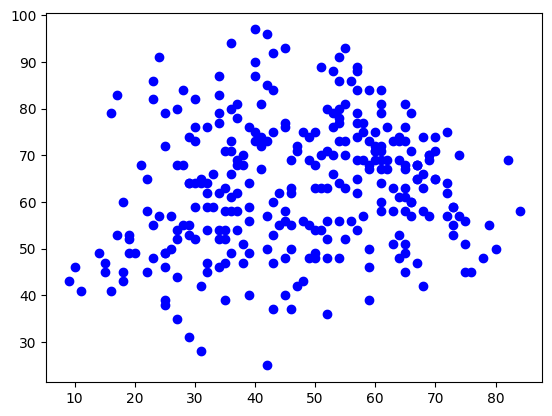

In [8]:
import random

random_seed = 6
data_freq = 300
# data = data_arr[:data_freq, :]
random.seed(random_seed)
indices = random.sample(range(data_arr.shape[0]), data_freq)

data = data_arr[indices, :]

plt.plot(data[:, 0], data[:, 1], marker='o', linestyle=' ', color='blue', label='Bike Data')

In [9]:
def _1flat(p1, p2):
    '''
    Returns the m, c values from the eqn y = mx + c, which is the eqn of the line formed by joining points p1 and p2
    If p1 == p2, we return line with slope 1
    If p1_x == p2_x, m = None and c = x_intercept
    Otherwise, m = slope and c = y_intercept
    '''
    
    if (p2[0] == p1[0]):
        if (p2[1] == p1[1]):
            return 1, p1[1] - p1[0]
        
        return None, p1[0]
    
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = round(p1[1] - m*p1[0], 2)
    
    return round(m, 2), c

In [10]:
import math

def find_dist(pt, line):
    if line[0] == None:
        return math.fabs(pt[0] - line[1])
    
    numerator = math.fabs(line[0]*pt[0] - pt[1] + line[1])
    denominator = math.sqrt(1 + line[0]**2)
    
    return round(numerator/denominator, 7)

def find_min_dist(pt, F):
    F = list(F)
    min_dist = find_dist(pt, F[0])
    for line in F[1:]:
        cur_dist = find_dist(pt, line)
        min_dist = min(min_dist, cur_dist)
    
    return min_dist

In [11]:
import heapq

def Approx_k_j_Flats(P, C, k=2, j=1):
#     C = 25
    
    t = 1
    Q = P
    F = set()
    
    while Q.shape[0] >= C*k*(j+1):
#         S_len = int(np.log2((j+1)) + min(t, np.log2(np.log2(data_freq))))
        S_len = 1
#         random.seed(7*t-1) # 1, 3, 5
        indx_S0 = random.sample(range(Q.shape[0]), S_len)
#         random.seed(7*t)   # 2, 4, 6
        indx_S1 = random.sample(range(Q.shape[0]), S_len)
        
        F_ = set()
        for i in range(S_len):
            for j in range(S_len):
                F_.add(_1flat(Q[indx_S0[i]], Q[indx_S1[j]]))
        
        F.update(F_)
        
        min_dist_rec = [] # Contains lists [dist, indx] as elements where dist = min distance of Q[indx] from closest line
        Q_index = 0
        for pt in Q:
            min_dist_rec.append((-1*find_min_dist(pt, F_), Q_index))
            Q_index += 1
        
        heapq.heapify(min_dist_rec)
        
        Q_ = []
        for i in range(Q.shape[0]//2):
            Q_.append(Q[heapq.heappop(min_dist_rec)[1]])
        
        Q = np.array(Q_)
        t += 1
    
    for pt1 in Q:
        for pt2 in Q:
            F.add(_1flat(pt1, pt2))
    
    return Q, F.copy()

In [12]:
# test

C = 1

k=2
j=1
t = 1
Q = data
F = set()

S_len = int(2 + np.log2(k*(j+1)) + min(t, np.log2(np.log2(data_freq))))
indx_S0 = random.sample(range(Q.shape[0]), S_len)
indx_S1 = random.sample(range(Q.shape[0]), S_len)

F_ = set()
for i in range(S_len):
    for j in range(S_len):
        F_.add(_1flat(Q[indx_S0[i]], Q[indx_S1[j]]))



In [13]:
def plotPoint(P, clr):
    plt.plot(P[:, 0], P[:, 1], marker='o', linestyle=' ', color=clr)
    
def plotLine(m, c, clr):
    if m==None:
        x1, y1, x2, y2 = c, 0, c, 100
    elif m==0:
        x1, y1, x2, y2 = 0, c, 100, c
    else:
        x1, y1, x2, y2 = 0, c, -c/m, 0
    if x2!=x1:
        x = np.linspace(min(x1, x2) - 100, max(x1, x2) + 100, 100)        
        y = m * (x - x1) + y1
        plt.plot(x, y, linestyle='-', color=clr)
    else:
        plt.plot([x1, y1], [x2, y2], linestyle='-', color=clr)

In [14]:
def find_k_j_flats(data, C):
    Q_2, F_2 = Approx_k_j_Flats(data, C)
    F_2 = list(F_2)

#     plotPoint(Q_2, 'red')
#     for line in F_2:
#         plotLine(line[0], line[1])
    
#     plotPoint(Q_2, 'red')

#     data_view = data.view([('', data.dtype)] * data.shape[1])
#     Q_2_view = Q_2.view([('', Q_2.dtype)] * Q_2.shape[1])

#     Q_3 = np.setdiff1d(data_view, Q_2_view).view(data.dtype).reshape(-1, data.shape[1])

#     plotPoint(Q_3, 'blue')
#     plt.xlim(-25, 100)
#     plt.ylim(-25, 125)
#     plt.show()
    
    return F_2

In [15]:
def find_optimal_l_centrum(F, l, P):
    flag = True
    optimalLine = None
    optimalDistances = []
    closestDistances = []
    first_line_flag = True
    
    for line in F:
        distances = []
        for pt in range(len(P)):
            d = find_dist(P[pt], line)
            distances.append(d)
            
            if first_line_flag:
                closestDistances.append(d)
            else:
                closestDistances[pt] = min(closestDistances[pt], d)
        
        first_line_flag = False
        distances.sort(reverse=True)
        
        max_l_sum = sum(distances[:l])
        
        if flag:
            optimalDistance = max_l_sum
            flag = False
            
        optimalDistance = min(optimalDistance, max_l_sum)
        
        if optimalDistance == max_l_sum:
            optimalLine = line
            optimalDistances = distances
            
    closestDistances.sort(reverse=True)
    return optimalLine, optimalDistances, closestDistances

In [16]:
def find_optimal_dist_sum(data, l, F):
    L_1, D_1, D_n = find_optimal_l_centrum(F, l, data)
    optimal_max_l_dist_sum  = sum(D_1[:l])
    optimal_closest_l_dist_sum = sum(D_n[:l])

#     plotPoint(data, 'red')
#     plotLine(L_1[0], L_1[1])

#     plt.xlim(-25, 100)
#     plt.ylim(-25, 125)
#     plt.show()

    return optimal_closest_l_dist_sum, optimal_max_l_dist_sum, L_1

In [ ]:
%%time

min_dist_overall_rec = []
closest_dist_overall_rec = []

for iter in range(500):
    print(iter)
    min_dist_sum = [-1, -1, -1]
    optimal_line = [None, None, None]
    optimal_C = [0, 0, 0]
    ell_values = [1, data.shape[0]//2, data.shape[0]]
    min_dist_rec = [[], [], []]
    closest_dist_rec = [[], [], []]

    for i in range(1, 15):
        F = find_k_j_flats(data, i)
        for l in range(3):
            cur_closest_sum, cur_dist_sum, cur_line = find_optimal_dist_sum(data, ell_values[l], F)
            if i == 5 or cur_dist_sum < min_dist_sum[l]:
                min_dist_sum[l] = cur_dist_sum
                optimal_line[l] = cur_line
                optimal_C[l] = i
            
            closest_dist_rec[l].append(cur_closest_sum)
            min_dist_rec[l].append(cur_dist_sum)
    
    closest_dist_overall_rec.append(closest_dist_rec)
    min_dist_overall_rec.append(min_dist_rec)
    
#     for l in range(3):
#         plt.subplot(3, 1, l + 1)
#         plt.plot(range(1, 15), min_dist_rec[l])
#         plt.plot([11], [min_dist_rec[l][10]], marker='o', linestyle=" ", color="red")
#         plt.title("ell = " + str(ell_values[l]))
#         plt.xlabel("Values of C")
#         if l==1:
#             plt.ylabel("Sum of 'ell' max distances")
    #     plt.ylim(0, None)

#     plt.show()

min_dist_overall_rec = np.array(min_dist_overall_rec)
closest_dist_overall_rec = np.array(closest_dist_overall_rec)
mean_min_dist = [[], [], []]
mean_closest_dist = [[], [], []]
for i in range(1, 15):
    mean_min_dist[0].append(np.mean(min_dist_overall_rec[:, 0, i-1]))
    mean_min_dist[1].append(np.mean(min_dist_overall_rec[:, 1, i-1]))
    mean_min_dist[2].append(np.mean(min_dist_overall_rec[:, 2, i-1]))
    mean_closest_dist[0].append(np.mean(closest_dist_overall_rec[:, 0, i-1]))
    mean_closest_dist[1].append(np.mean(closest_dist_overall_rec[:, 1, i-1]))
    mean_closest_dist[2].append(np.mean(closest_dist_overall_rec[:, 2, i-1]))

# print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[0])) + 1))
# print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[1])) + 1))
# print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[2])) + 1))

# for l in range(3):
#     plt.subplot(3, 1, l + 1)
#     plt.plot(range(1, 15), mean_dist[l])
#     plt.plot([11], [mean_dist[l][10]], marker='o', linestyle=" ", color="red")
#     plt.title("ell = " + str(ell_values[l]))
#     plt.xlabel("Values of C")
#     if l==1:
#         plt.ylabel("Mean Sum of 'ell' max distances")

# plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [ ]:
print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[0])) + 1))
print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[1])) + 1))
print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[2])) + 1))

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 15), mean_min_dist[l])
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Mean Sum of 'ell' max distances")

plt.show()

In [ ]:
print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[0])) + 1))
print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[1])) + 1))
print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[2])) + 1))

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 15), mean_closest_dist[l])
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Mean Sum of 'ell' max closest distances")

plt.show()

In [ ]:
min_dist_sum = [-1, -1, -1]
line_C_13 = [None, None, None]
optimal_C = [0, 0, 0]
ell_values = [1, data.shape[0]//2, data.shape[0]]
min_dist_rec = [[], [], []]
closest_dist_rec = [[], [], []]
line_C_13 = [None, None, None]
F_len_rec = []

for i in range(1, 15):
    F = find_k_j_flats(data, i)
    print(i, len(F))
    F_len_rec.append(len(F))
    for l in range(3):
        closest_dist_sum, cur_dist_sum, cur_line = find_optimal_dist_sum(data, ell_values[l], F)
        min_dist_rec[l].append(cur_dist_sum)
        closest_dist_rec[l].append(closest_dist_sum)
        
        if i == 5 or cur_dist_sum < min_dist_sum[l]:
            min_dist_sum[l] = cur_dist_sum
            optimal_line[l] = cur_line
            optimal_C[l] = i
        
        if i == 13:
            line_C_13[l] = cur_line

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 15), min_dist_rec[l])
    plt.plot(range(1, 15), closest_dist_rec[l])
    plt.plot([13], [min_dist_rec[l][12]], marker='o', linestyle=" ", color="red")
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Sum of 'ell' max distances")
#     plt.ylim(0, None)

plt.show()

In [ ]:
plotPoint(data, "red")
plotLine(line_C_13[0][0], line_C_13[0][1], clr="blue")
plotLine(line_C_13[1][0], line_C_13[1][1], clr="green")
plotLine(line_C_13[2][0], line_C_13[2][1], clr="orange")
plt.xlim(-25, 100)
plt.ylim(-25, 125)

plt.show()

In [ ]:
import pandas as pd

data_lines = {
    'C': range(1,15),
    'No. of Lines':F_len_rec
}

df_lines = pd.DataFrame(data_lines).T

print(df_lines)

In [ ]:
data_l_1 = {
    'C' : range(1, 15),
    'All of F': mean_closest_dist[0],
    '1 Optimal Line from F': mean_min_dist[0]
}

df_1 = pd.DataFrame(data_l_1)

print("ell =", ell_values[0])
print()
print(df_1)

In [ ]:
import pandas as pd

# mean_min_dist = np.array(mean_min_dist)
# mean_closest_dist = np.array(mean_closest_dist)

data_l_half = {
    'C' : range(1, 15),
    'All of F': mean_closest_dist[1],
    '1 Optimal Line from F': mean_min_dist[1]
}

df_half = pd.DataFrame(data_l_half)

print("ell =", ell_values[1])
print()
print(df_half)

In [ ]:
import pandas as pd

# mean_min_dist = np.array(mean_min_dist)
# mean_closest_dist = np.array(mean_closest_dist)

data_l_full = {
    'C' : range(1, 15),
    'All of F': mean_closest_dist[2],
    '1 Optimal Line from F': mean_min_dist[2]
}

df_full = pd.DataFrame(data_l_full)

print("ell =", ell_values[2])
print()
print(df_full)